# Asimov significance

In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [5]:
def rename_column(ev_dict, old_name, new_name):
    for year in ev_dict:
        for ch in ev_dict[year]:
            for sample in ev_dict[year][ch]:
                df = ev_dict[year][ch][sample]
                df[new_name] = df[old_name]
                
                # drop old column
                df = df[df.columns.drop(list(df.filter(regex=old_name)))]

# tagger_old = "fj_ParT_score_finetuned_v2_1-12"
# tagger_new = "fj_ParT_score_finetuned_v2_1_12"
# rename_column(events_dict, tagger_old, tagger_new)                

# Should we categorize?

In [8]:
# at jet pt > 250 and MET cut

###########

# WP1
tagger_cuts = [
#     0.95,
#     0.955,
    0.96,
    0.965,
    0.97,
    0.975,
    0.98,
    0.985,
#     0.99,
]

# with ggF and VBF splitting
sig_ggFandVBF = [
#     ,   # 0.95
#     ,   # 0.955
    1.5753,   # 0.96
    1.60615,   # 0.965    
    1.72512,   # 0.97
    1.79461,   # 0.975    
    1.80901,   # 0.98
    1.7271,   # 0.985
#     0,   # 0.99    
]

# without ggF and VBF splitting
sig = [
#     ,   # 0.95
#     ,   # 0.955
    1.02247,   # 0.96
    1.06089,   # 0.965    
    1.20645,   # 0.97
    1.45288,   # 0.975    
    1.50477,   # 0.98
    1.44718,   # 0.985 
#   ,   # 0.99
]

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

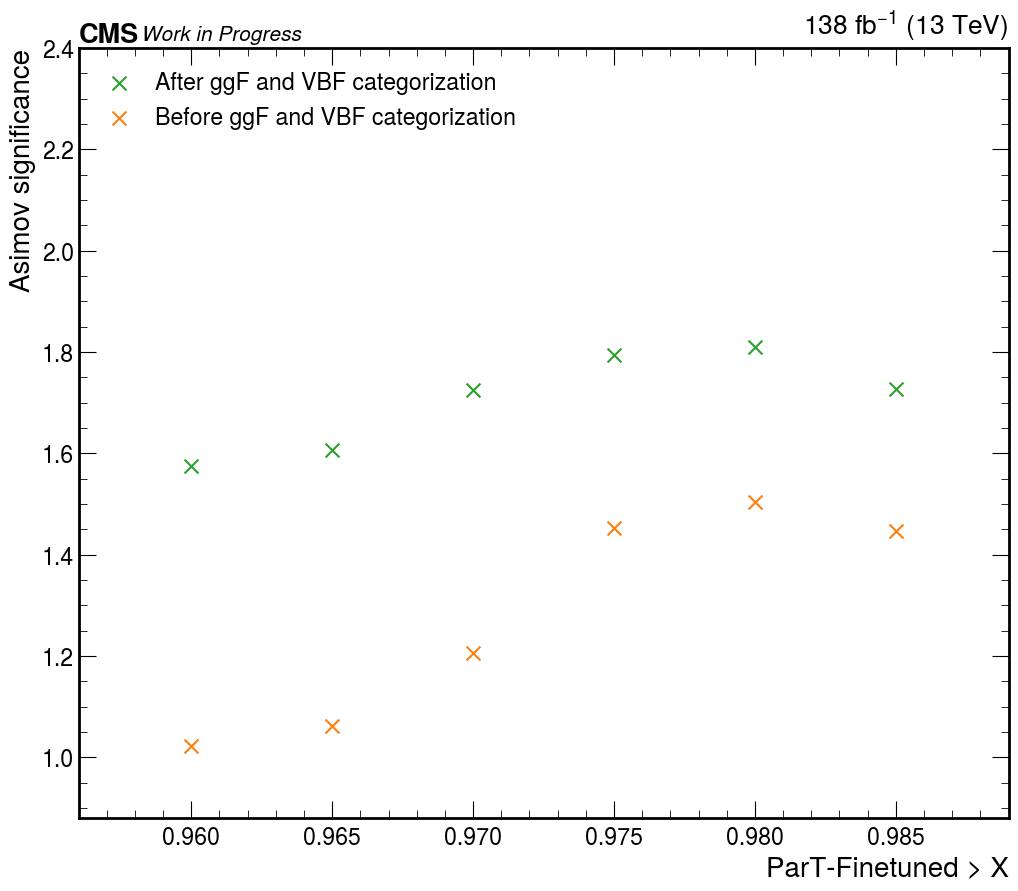

In [9]:
color_dict = {    
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:green",   
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
}


plt.rcParams.update({"font.size": 20})

years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

fig, ax = plt.subplots(figsize=(12, 10))

ax.scatter(tagger_cuts, sig_ggFandVBF, marker="x", s=100, label="After ggF and VBF categorization", color="tab:green")
ax.scatter(tagger_cuts, sig, marker="x", s=100, label="Before ggF and VBF categorization", color="tab:orange")

# ax.plot([0.975, 0.975], [0.3, 2.00251], ':', color='grey')
# ax.plot([0.3, 0.975], [2.00251, 2.00251], ':', color='grey')

# ax.plot([0.985, 0.985], [0.3, 1.67914], ':', color='grey')
# ax.plot([0.3, 0.985], [1.67914, 1.67914], ':', color='grey')

ax.set_xlim(0.956, 0.989)
ax.set_ylim(0.88, 2.4)

# ax.set_ylim(0, 1.4)
ax.legend(loc="upper left")
ax.set_ylabel("Asimov significance")
ax.set_xlabel(f"ParT-Finetuned > X")

# ax.set_xticks(tagger_cuts)

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# plt.savefig(f"/Users/fmokhtar/Desktop/AN/significance-cats.pdf")

# WP1 (ggF and VBF)

In [119]:
# WP1
# reading from combine for WP1
tagger_cuts = [
    0.95,
    0.955,    
    0.96,
    0.965,
    0.97,
    0.975,
    0.98,
    0.985,
#     0.99,
]
sig_vbf = [
    1.29797,   # 0.95
    1.28452,   # 0.955    
    1.41709,   # 0.96
    1.43333,   # 0.965    
    1.45732,   # 0.97
    1.53811,   # 0.975    
    1.5858,   # 0.98
    1.55601,   # 0.985    
#     0, # 0.99
]
sig_ggf_inclusive = [
    0.862802,   # 0.95
    0.940192,   # 0.955    
    0.972933,   # 0.96
    0.986194,   # 0.965    
    1.12346,   # 0.97
    1.24184,   # 0.975    
    1.24618,   # 0.98
    1.20175,   # 0.985    
#     1.02185, # 0.99
]
sig_ggf_combined = [
    1.03403,   # 0.95
    1.13388,   # 0.955    
    1.16589,   # 0.96
    1.1932,   # 0.965    
    1.30952,   # 0.97
    1.36201,   # 0.975    
    1.34024,   # 0.98
    1.31319,   # 0.985    
]

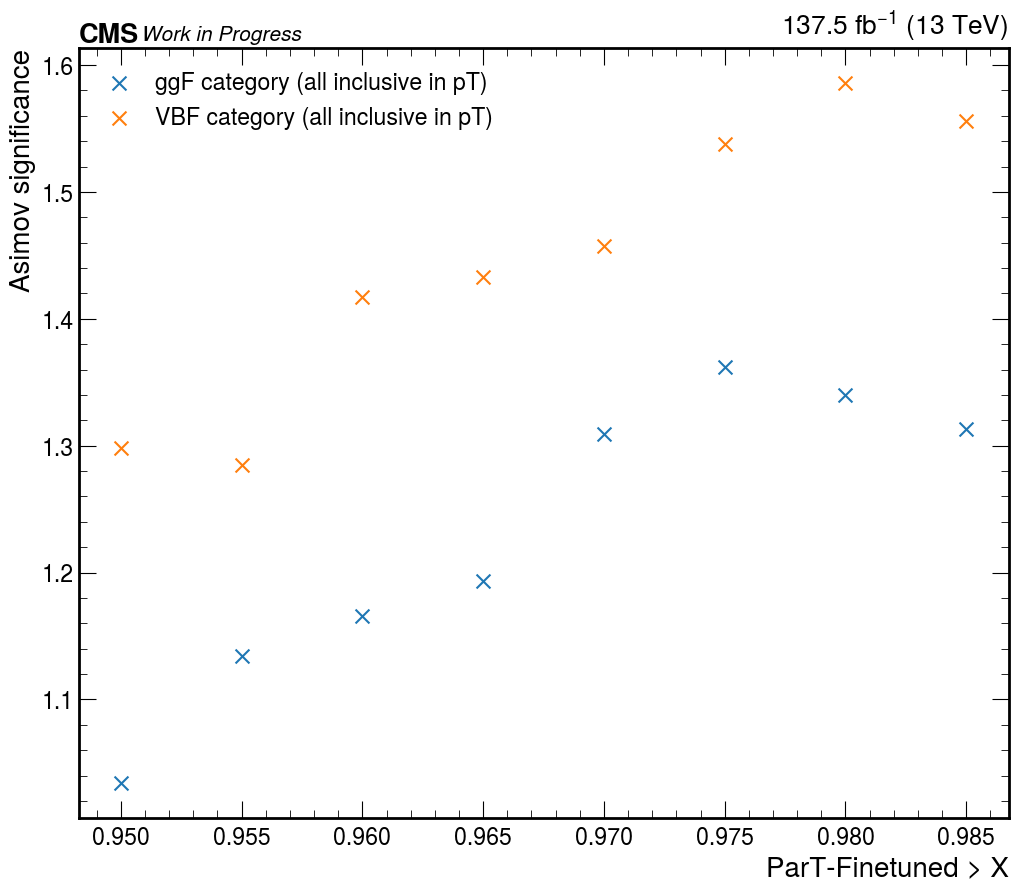

In [120]:
color_dict = {    
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:green",   
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
}


plt.rcParams.update({"font.size": 20})


years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

fig, ax = plt.subplots(figsize=(12, 10))

for tagger in [
#     "fj_ParT_score",
    "fj_ParT_score_finetuned",
]:
    ax.scatter(tagger_cuts, sig_ggf_combined, marker="x", s=100, label="ggF category (all inclusive in pT)")
    ax.scatter(tagger_cuts, sig_vbf, marker="x", s=100, label="VBF category (all inclusive in pT)")

# ax.plot([0.97, 0.97], [0.957, 1.47527], ':', color='grey')
# ax.plot([0.957, 0.97], [1.47527, 1.47527], ':', color='grey')

# ax.plot([0.985, 0.985], [0.957, 1.31084], ':', color='grey')
# ax.plot([0.957, 0.985], [1.31084, 1.31084], ':', color='grey')

# ax.set_xlim(0.957, 0.991)
# ax.set_ylim(1., 1.7)
ax.legend()
ax.set_ylabel("Asimov significance")
ax.set_xlabel("ParT-Finetuned > X")

# ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])

# ax.set_xticks(tagger_cuts)


hep.cms.lumitext("%.1f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/significance-WP1.pdf")

In [121]:
sig_SR1 = 1.97085 # assumes 0.98 for ggF and 0.97 for VBF
WP1 = 0.98

# WP1
# reading from combine for WP1
tagger_cuts = [
    0.96,
    0.965,
    0.97,
    0.975,
]
sig = [
    2.02862,   # 0.96
    2.02283,   # 0.965
    2.02771,   # 0.97
    2.01843,   # 0.975
]

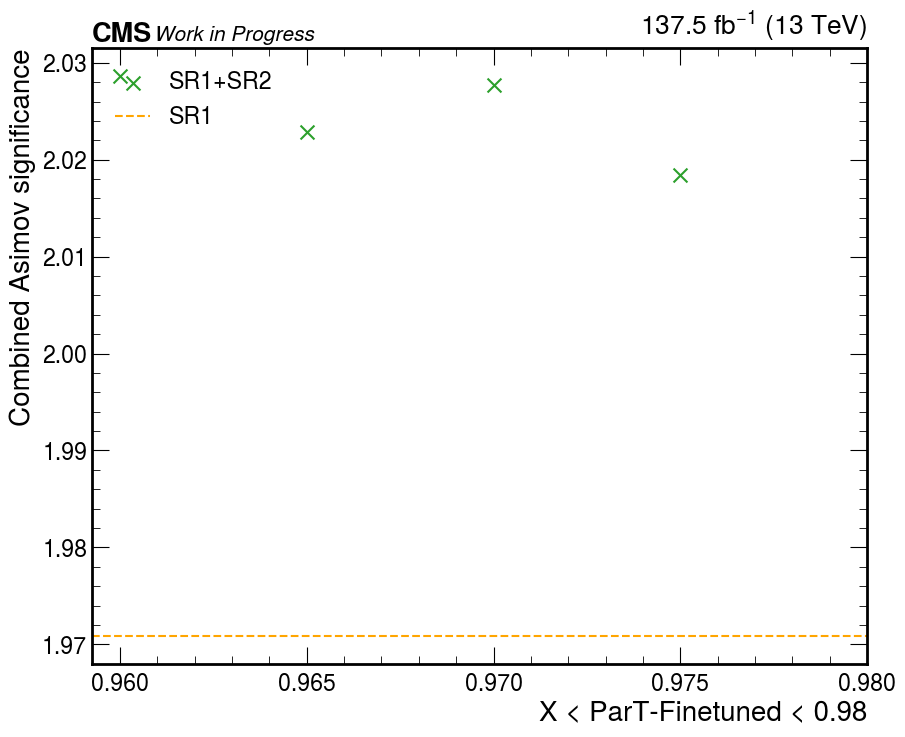

In [123]:
color_dict = {    
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:green",   
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
}


plt.rcParams.update({"font.size": 20})


years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

fig, ax = plt.subplots(figsize=(10, 8))

for tagger in [
#     "fj_ParT_score",
    "fj_ParT_score_finetuned",
]:
    ax.scatter(tagger_cuts, sig, marker="x", s=100, label="SR1+SR2", color=color_dict[tagger])

ax.axhline(sig_SR1, color="orange", linestyle="--", label=rf"SR1")

# ax.plot([0.97, 0.97], [1.9, 2.08796], ':', color='grey')
# ax.plot([0.959, 0.97], [2.08796, 2.08796], ':', color='grey')

# ax.set_xlim(0.959, 0.982)
# ax.set_ylim(1.9, 2.2)


ax.legend(loc="upper left")
ax.set_ylabel("Combined Asimov significance")
ax.set_xlabel(f"X < ParT-Finetuned < {WP1}")

ax.set_xticks([0.96, 0.965, 0.97, 0.975, 0.98])

# ax.set_xticks(tagger_cuts)


hep.cms.lumitext("%.1f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/significance-WP2.pdf")

# WP2

In [49]:
WP1 = 0.985   # sig=1.50482
sig = [
    1.52971,  # 0.985>tagger>0.80
    1.52975,  # 0.985>tagger>0.81
    1.53179,  # 0.985>tagger>0.82
    1.53182,  # 0.985>tagger>0.83
    1.53539,  # 0.985>tagger>0.84
    1.53678,  # 0.985>tagger>0.85
    1.54087,  # 0.985>tagger>0.86
    1.54509,  # 0.985>tagger>0.87
    1.54951,  # 0.985>tagger>0.88
    1.55866,  # 0.985>tagger>0.89
    1.55811,  # 0.985>tagger>0.90
    1.5534,  # 0.985>tagger>0.91
    1.56035,  # 0.985>tagger>0.92
    1.5756,  # 0.985>tagger>0.93
    1.60867,  # 0.985>tagger>0.94
    1.61182,  # 0.985>tagger>0.95
    1.67882,  # 0.985>tagger>0.96
    1.70185,  # 0.985>tagger>0.965
    1.73103,  # 0.985>tagger>0.97
    1.67332,  # 0.985>tagger>0.975
    1.63166,  # 0.985>tagger>0.98
    1.59202,  # 0.985>tagger>0.9825   
]
tagger_cuts = [
    0.80,
    0.81,
    0.82,
    0.83,
    0.84,
    0.85,
    0.86,
    0.87,
    0.88,
    0.89,
    0.90,
    0.91,
    0.92,
    0.93,
    0.94,
    0.95,
    0.96,
    0.965,
    0.97,
    0.975,
    0.98,
    0.9825,
]

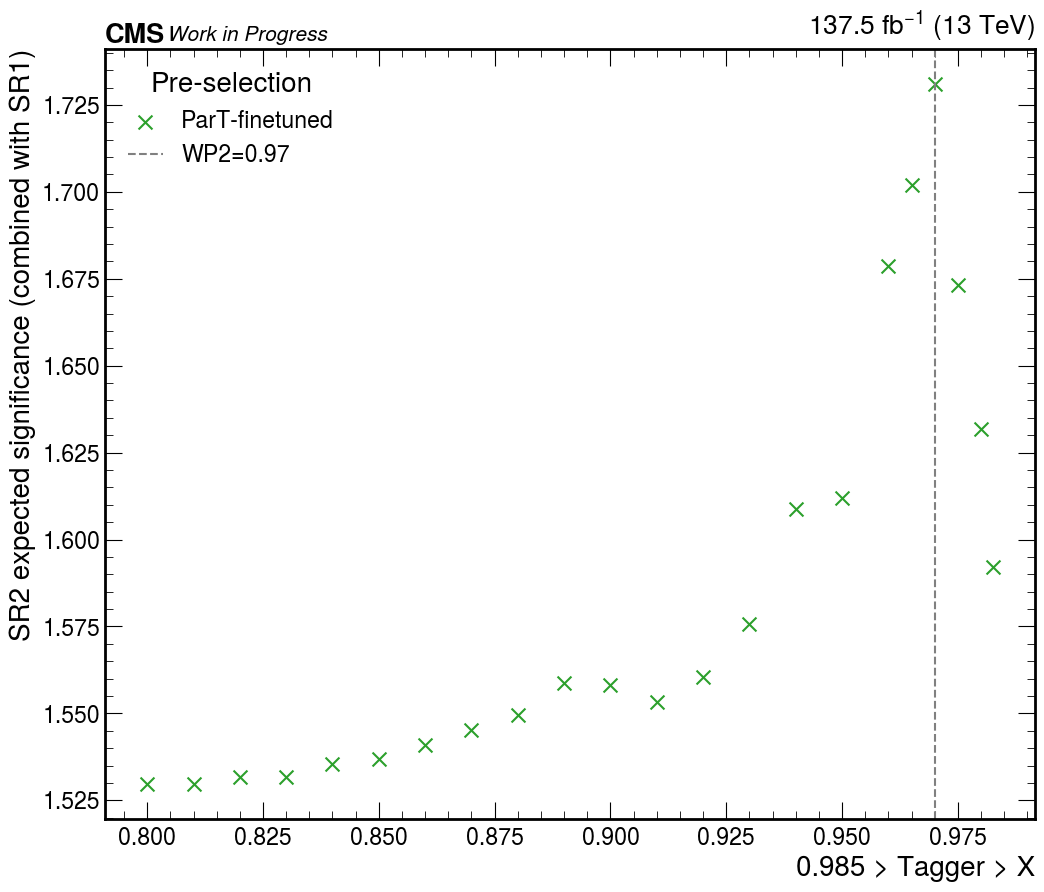

In [50]:
color_dict = {    
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:green",   
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
}


plt.rcParams.update({"font.size": 20})


years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

fig, ax = plt.subplots(figsize=(12, 10))

for tagger in [
#     "fj_ParT_score",
    "fj_ParT_score_finetuned",
]:
    
    ax.scatter(tagger_cuts, sig, marker="x", s=100, label=lab_dict[tagger], color=color_dict[tagger])

ax.axvline(0.97, color="grey", linestyle="--", label=rf"WP2=0.97")

# ax.set_ylim(0, 1.4)
ax.legend(title="Pre-selection")
ax.set_ylabel("SR2 expected significance (combined with SR1)")
ax.set_xlabel(f"{WP1} > Tagger > X")
# ax.set_xticks(tagger_cuts)

hep.cms.lumitext("%.1f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/signicance-WP2.pdf")

In [47]:
WP1 = 0.97    # sig=1.3969
sig = [
    1.41648,  # 0.97>tagger>0.80
    1.41568,  # 0.97>tagger>0.81
    1.416,  # 0.97>tagger>0.82
    1.41532,  # 0.97>tagger>0.83
    1.41636,  # 0.97>tagger>0.84
    1.41523,  # 0.97>tagger>0.85
    1.4157,  # 0.97>tagger>0.86
    1.41774,  # 0.97>tagger>0.87
    1.41867,  # 0.97>tagger>0.88
    1.41859,  # 0.97>tagger>0.89
    1.41733,  # 0.97>tagger>0.90
    1.41284,  # 0.97>tagger>0.91
    1.41211,  # 0.97>tagger>0.92
    1.41973,  # 0.97>tagger>0.93
    1.42414,  # 0.97>tagger>0.94
    1.42296,  # 0.97>tagger>0.95
    1.42592,  # 0.97>tagger>0.96
    1.42106,  # 0.97>tagger>0.965
    1.41098,  # 0.97>tagger>0.9675  
]
tagger_cuts = [
    0.80,
    0.81,
    0.82,
    0.83,
    0.84,
    0.85,
    0.86,
    0.87,
    0.88,
    0.89,
    0.90,
    0.91,
    0.92,
    0.93,
    0.94,
    0.95,
    0.96,
    0.965,
    0.9675,
]

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

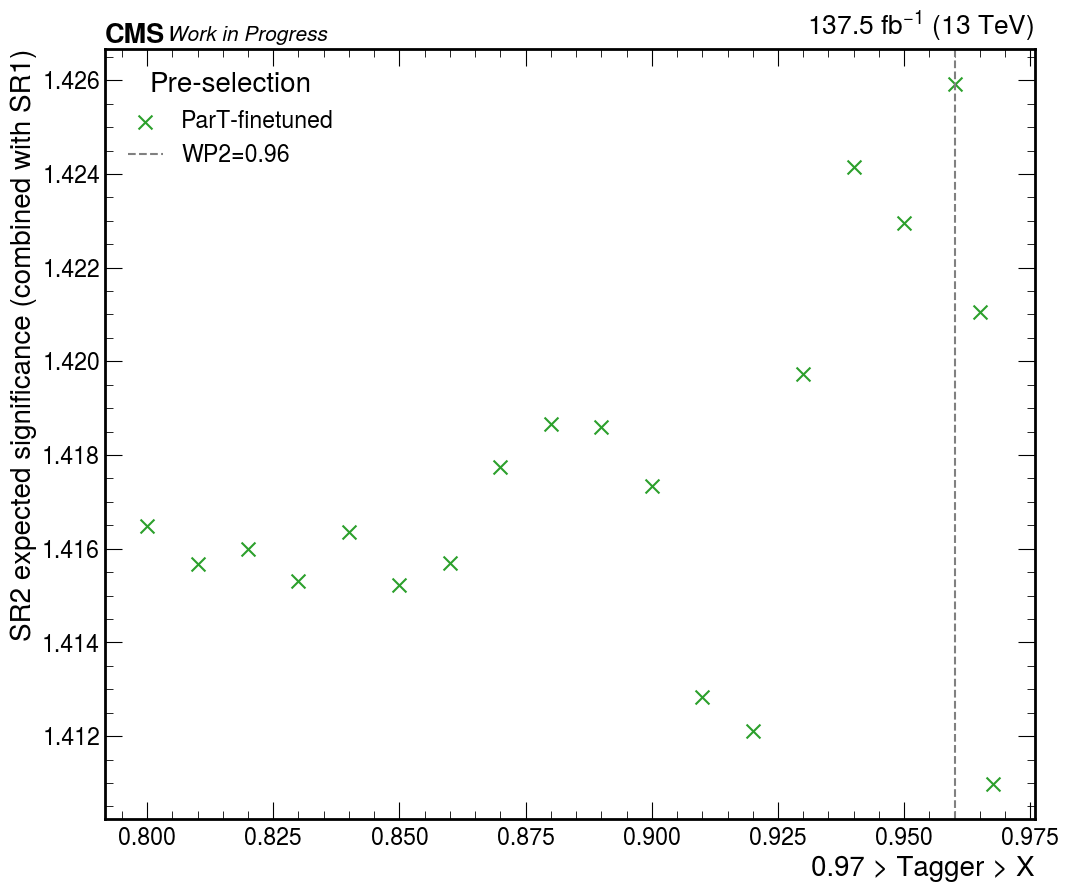

In [48]:
color_dict = {    
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:green",   
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
}


plt.rcParams.update({"font.size": 20})


years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

fig, ax = plt.subplots(figsize=(12, 10))

for tagger in [
#     "fj_ParT_score",
    "fj_ParT_score_finetuned",
]:
    
    ax.scatter(tagger_cuts, sig, marker="x", s=100, label=lab_dict[tagger], color=color_dict[tagger])

ax.axvline(0.96, color="grey", linestyle="--", label=rf"WP2=0.96")

# ax.set_ylim(0, 1.4)
ax.legend(title="Pre-selection")
ax.set_ylabel("SR2 expected significance (combined with SR1)")
ax.set_xlabel(f"{WP1} > Tagger > X")
# ax.set_xticks(tagger_cuts)

hep.cms.lumitext("%.1f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/soverb_medium_signal_region.pdf")